Fetching data for HINDUNILVR.NS...


[*********************100%***********************]  1 of 1 completed


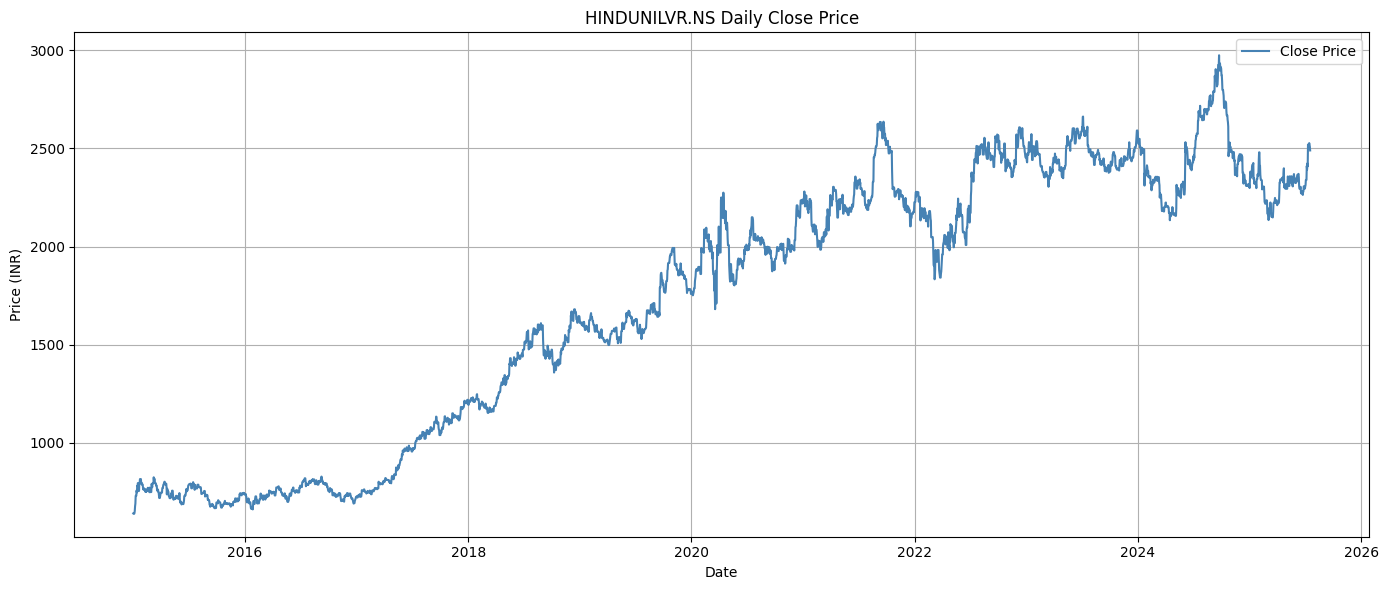


Evaluation on Test Data:
MAE: 305.25
RMSE: 358.16


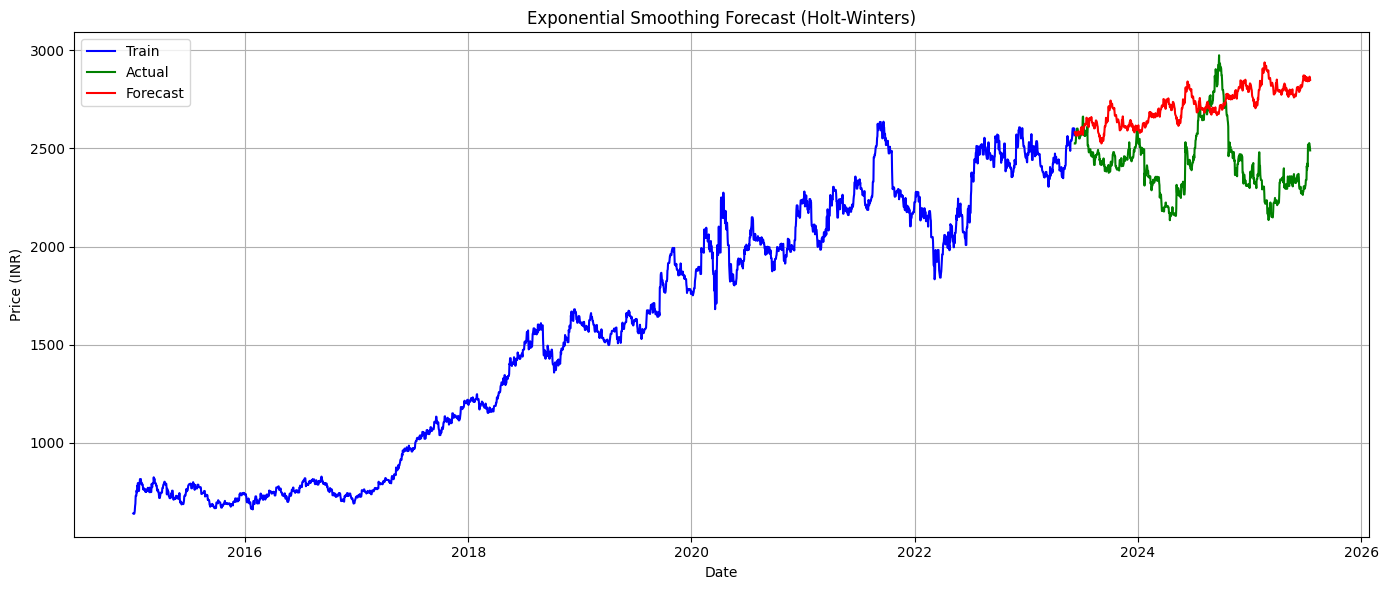

In [1]:
# --- Imports and Setup ---
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

# --- 1. Configuration ---
STOCK_TICKER = 'HINDUNILVR.NS'
START_DATE = '2015-01-01'
END_DATE = '2025-07-20'

# --- 2. Data Collection ---
print(f"Fetching data for {STOCK_TICKER}...")
df = yf.download(STOCK_TICKER, start=START_DATE, end=END_DATE)
if df.empty:
    raise ValueError("Data fetch failed. Check ticker or internet connection.")

df_close = df[['Close']].copy()
df_close.index = pd.to_datetime(df_close.index)
df_close = df_close.asfreq('D')  # daily frequency
df_close.ffill(inplace=True)
df_close.bfill(inplace=True)

# --- 3. Visualization ---
plt.figure(figsize=(14, 6))
plt.plot(df_close['Close'], label='Close Price', color='steelblue')
plt.title(f'{STOCK_TICKER} Daily Close Price')
plt.xlabel('Date'); plt.ylabel('Price (INR)')
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

# --- 4. Train-Test Split ---
train_size = int(len(df_close) * 0.8)
train_data = df_close.iloc[:train_size]
test_data = df_close.iloc[train_size:]

# --- 5. Exponential Smoothing Model ---
seasonal_period = 252  # Weekly seasonality (daily data)

model = ExponentialSmoothing(
    train_data['Close'],
    trend='add',
    seasonal='mul',
    seasonal_periods=seasonal_period
).fit()

# Forecasting
forecast = model.forecast(len(test_data))

# --- 6. Evaluation ---
mae = mean_absolute_error(test_data['Close'], forecast)
rmse = np.sqrt(mean_squared_error(test_data['Close'], forecast))
print(f"\nEvaluation on Test Data:\nMAE: {mae:.2f}\nRMSE: {rmse:.2f}")

# --- 7. Plot Results ---
plt.figure(figsize=(14, 6))
plt.plot(train_data.index, train_data['Close'], label='Train', color='blue')
plt.plot(test_data.index, test_data['Close'], label='Actual', color='green')
plt.plot(test_data.index, forecast, label='Forecast', color='red')
plt.title('Exponential Smoothing Forecast (Holt-Winters)')
plt.xlabel('Date'); plt.ylabel('Price (INR)')
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


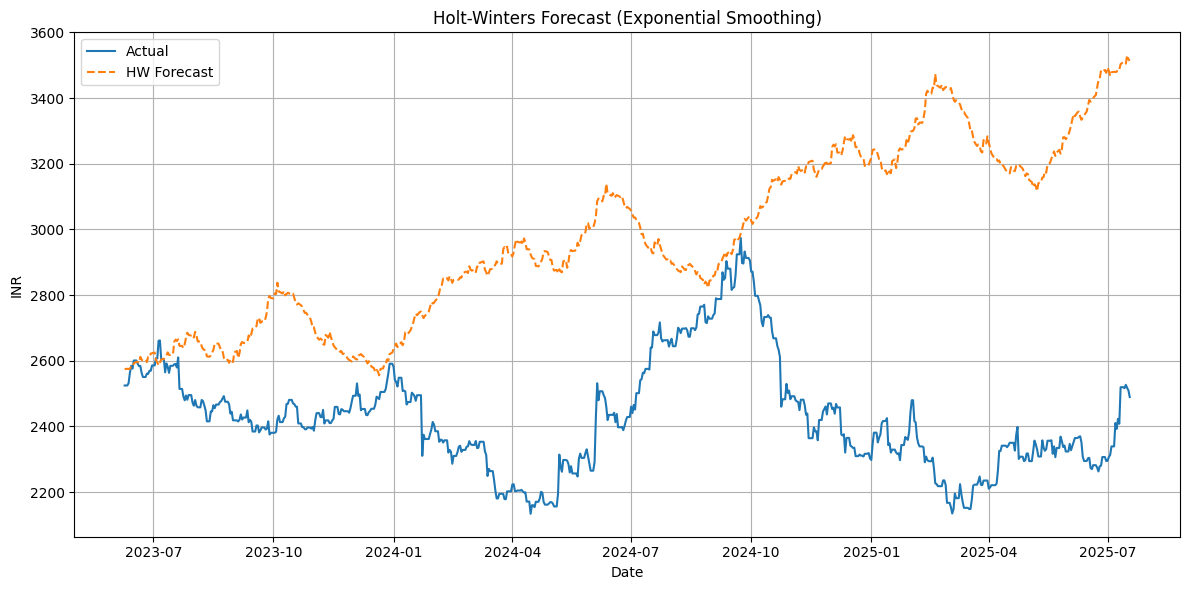

MSE: 426543.75
MAE: 547.49


In [2]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Take log to stabilize variance
train_data['LogClose'] = np.log(train_data['Close'])
test_data['LogClose'] = np.log(test_data['Close'])

# Holt-Winters with daily seasonality
hw_model = ExponentialSmoothing(train_data['LogClose'],
                                trend='add',
                                seasonal='mul',
                                seasonal_periods=252,
                                initialization_method="estimated").fit()

# Forecast & convert back to original scale
log_forecast = hw_model.forecast(len(test_data))
forecast = np.exp(log_forecast)

# Plot
plt.figure(figsize=(12,6))
plt.plot(test_data.index, test_data['Close'], label='Actual')
plt.plot(test_data.index, forecast, label='HW Forecast', linestyle='--')
plt.title('Holt-Winters Forecast (Exponential Smoothing)')
plt.xlabel('Date'); plt.ylabel('INR')
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()

# Evaluation
print(f"MSE: {mean_squared_error(test_data['Close'], forecast):.2f}")
print(f"MAE: {mean_absolute_error(test_data['Close'], forecast):.2f}")
